## Introduction
From Kaggle open resource, we had **training** dataset, **public test** dataset (which is then used as validation dataset for our project), and further a **private test** dataset (same size with public test dataset and will be used as data for evaluating the prediction performance).

Image set of 35,887 examples, with training-set : **80%** validation-set : **10%** test-set : **10%**.

## Objectives
(i) To apply Convolutional neural networks (CNN) for facial expression recognition.
 
(ii) To correctly classify each facial image into one of the seven facial emotion categories: **anger**, **disgust**, **fear**, **happiness**, **sadness**, **surprise**, and **neutral**.


---------------------------------------------------------------------------------------
## Import libraries

In [6]:
!pip install tensorflow


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Keerthy Chawla\\anaconda3\\Lib\\site-packages\\~umpy\\core\\_multiarray_tests.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Created wheel for jax: filename=jax-0.4.12-py3-none-any.whl size=1498562 sha256=621d9cde693384a5600b470938c5b205a6915c0a2efe08d0e9ed10da7faeaa6a
  Stored in directory: c:\users\keerthy chawla\appdata\local\pip\cache\wheels\ca\6c\0b\dab434867ee492673dd15dbf9f6cce85781b555432a92bfb10
Successfully built jax
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3


In [7]:
!pip install keras

  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)


In [ ]:
!pip install scikit-learn

In [ ]:
import tensorflow as tf
import sklearn

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tensorflow import keras

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir("..\input"))

## FER Dataset Overview 

In [23]:
data = pd.read_csv('../input/fer2013/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [ ]:
#preview first 5 row of data
data.head(5)

In [ ]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

In [ ]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

In [ ]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

#### Let's look at some images...

In [ ]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()  

----------------------------------------------------------------------------------
## Pre-processing data
#### Summary:
1. Splitting dataset into 3 parts: train, validation, test
1. Convert strings to lists of integers
1. Reshape to 48x48 and normalise grayscale image with 255.0
1. Perform one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

In [24]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
#data_train = data_train[data_train['emotion']!=1]
#data_val = data_val[data_val['emotion']!=1]
##data_test = data_test[data_test['emotion']!=1]
#data_train['emotion'] = data_train['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_test['emotion'] = data_test['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
#data_val['emotion'] = data_val['emotion'].apply(lambda ele: ele-1 if ele > 0 else ele)
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


In [ ]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Notice that the later two subplots share the same y-axis with the first subplot. 

The size of **train**, **validation**, **test** are **80%**, **10%** and **10%**, respectively. 

The exact number of each class of these datasets are written on top of their x-axis bar. 

In [25]:
#initilize parameters
num_classes = 7
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

In [26]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


# **CK+ OVERVIEW**

In [ ]:
import os
import cv2

data_path = '../input/ckplus/CK+48'
data_dir_list = os.listdir(data_path)

img_data_list=[]

numbers = []
c=0

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        input_img_resize = np.reshape(input_img_resize,(48,48,1))
        img_data_list.append(input_img_resize)
        c += 1
    numbers.append(c)
    c = 0
        
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

In [ ]:
pl = img_data
np.reshape(pl[0],(48,48,1))
pl[0].shape

In [ ]:


num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=6 #54
labels[189:365]=1 #177
labels[366:440]=2 #75
labels[441:647]=3 #207
labels[648:731]=4 #84
labels[732:980]=5 #249

names = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def getLabel(id):
    return ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][id]

In [ ]:
from keras.utils import np_utils, to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=2)

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(48, 48, 1))
    num_filters = 32
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2,3, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    #outputs = Dense(10, activation='softmax')(t)
    
    model = Model(inputs, t)

    return model

#output layer
#model.add(Dense(6,activation='softmax'))

In [63]:
pip install stn

Note: you may need to restart the kernel to use updated packages.


In [76]:
from tensorflow import keras
from keras import layers
from stn import spatial_transformer_network as transformer

img_inputs = keras.Input(shape=(48,48,1))

locnet = layers.Conv2D(32,3, padding='same')(img_inputs)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(64,3, padding='same')(locnet)
locnet = layers.MaxPooling2D(3, padding='same')(locnet)
locnet = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Conv2D(96,3, padding='same')(locnet)
feat_map = layers.Activation('relu')(locnet)
locnet = layers.BatchNormalization()(locnet)
locnet = layers.Flatten()(feat_map)
locnet = layers.Dense(90, activation='relu',kernel_regularizer='l2')(locnet)
locnet = layers.Dropout(0.2)(locnet)
locnet = layers.Dense(32, activation='relu', kernel_regularizer='l2')(locnet)
theta = layers.Dense(6, activation='linear')(locnet)

locnet = keras.Model(img_inputs, theta, name="locnet")
#locnet.summary()

#spatial transformer network
outstn = transformer(feat_map,theta)



#feature extraction network
fe = layers.Conv2D(32,3, padding='same')(img_inputs)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(64,3, padding='same')(fe)
fe = layers.BatchNormalization()(fe)
fe = layers.Activation('relu')(fe)
fe = layers.MaxPooling2D(3,padding='same')(fe)
fe = layers.Conv2D(96,3, padding='same')(fe)
fe = layers.Activation('relu')(fe)
do = layers.BatchNormalization()(fe)

fe = keras.Model(img_inputs, do, name="feature extractor")
#fe.summary()

add = layers.Add()([outstn, do])

flats = layers.Flatten()(add)
flats = layers.Dense(64, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
flats = layers.Dense(32, activation='relu',  kernel_regularizer='l2')(flats)
flats = layers.Dropout(0.4)(flats)
#output = layers.Dense(6, activation='softmax')(flats)

x1 = layers.Dense(7, activation='linear')(flats)
x2 = layers.Dense(7,activation='linear')(flats)
x3 = layers.Dense(7,activation='linear')(flats)
x4 = layers.Dense(7,activation='linear')(flats)
avg = layers.Average()([x1, x2, x3, x4])
out = layers.Dense(7, activation='softmax')(avg)

model = keras.Model(inputs=img_inputs, outputs=out, name="FEMSTN")

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.1,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(learning_rate=lr_schedule), 
              metrics=['accuracy'])

model.summary()

Model: "FEMSTN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, 48, 48, 32)   320         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_57 (MaxPooling2D) (None, 16, 16, 32)   0           conv2d_81[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 32)   0           max_pooling2d_57[0][0]           
_____________________________________________________________________________________________

In [27]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [99]:
from keras.layers import LeakyReLU

model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(48, 48, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 2
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(4*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#module 3
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))


#dense 4
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Dense(7, activation='softmax'))

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    0.01,
    decay_steps=100,
    decay_rate=0.5,
    staircase=False)

model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.Adam(0.01), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_116 (Conv2D)          (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_117 (Bat (None, 46, 46, 256)       1024      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_118 (Bat (None, 46, 46, 256)       1024      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 23, 23, 256)     

In [31]:
batch_size = 128
epochs = 100

from keras.layers import Average, Add
from keras.models import Model

model = create_res_net()

x1 = Dense(6)(model.output)
x2 = Dense(6)(model.output)
x3 = Dense(6)(model.output)
x4 = Dense(6)(model.output)
avg = Average()([x1, x2, x3, x4])
out = Dense(6, activation='softmax')(avg)
model = Model(inputs=model.input, outputs=out)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.1,
    decay_steps=1000,
    decay_rate=0.46,
    staircase=True)

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), 
              metrics=['accuracy'])

model.summary()

In [100]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True
)


es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)

cp_path = './model_bacc.h5'
cpl_path = './model_fer_bloss.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=cp_path,save_best_only=True, save_weights_only=False, verbose=0, monitor='val_accuracy')
cpl = tf.keras.callbacks.ModelCheckpoint(filepath=cpl_path,save_best_only=True, save_weights_only=False, verbose=2, monitor='val_loss')
history = model.fit(data_generator.flow(train_X, train_Y, 256),
                                epochs=100,
                                verbose=1, 
                                callbacks = [cp, cpl, es],
                                validation_data=(val_X, val_Y))

Epoch 1/100
113/113 [==============================] - 28s 237ms/step - loss: 1.9133 - accuracy: 0.2329 - val_loss: 1.8128 - val_accuracy: 0.2419

Epoch 00001: val_loss improved from inf to 1.81278, saving model to ./model_fer_bloss.h5
Epoch 2/100
113/113 [==============================] - 26s 233ms/step - loss: 1.6791 - accuracy: 0.3297 - val_loss: 1.9875 - val_accuracy: 0.2513

Epoch 00002: val_loss did not improve from 1.81278
Epoch 3/100
113/113 [==============================] - 26s 232ms/step - loss: 1.4573 - accuracy: 0.4324 - val_loss: 1.9572 - val_accuracy: 0.3784

Epoch 00003: val_loss did not improve from 1.81278
Epoch 4/100
113/113 [==============================] - 26s 233ms/step - loss: 1.3015 - accuracy: 0.5030 - val_loss: 1.4850 - val_accuracy: 0.4483

Epoch 00004: val_loss improved from 1.81278 to 1.48497, saving model to ./model_fer_bloss.h5
Epoch 5/100
113/113 [==============================] - 26s 233ms/step - loss: 1.2307 - accuracy: 0.5309 - val_loss: 1.3125 - val


Epoch 00039: val_loss did not improve from 0.99674
Epoch 40/100
113/113 [==============================] - 27s 234ms/step - loss: 0.6868 - accuracy: 0.7450 - val_loss: 1.0872 - val_accuracy: 0.6364

Epoch 00040: val_loss did not improve from 0.99674
Epoch 41/100
113/113 [==============================] - 27s 234ms/step - loss: 0.7059 - accuracy: 0.7387 - val_loss: 1.0423 - val_accuracy: 0.6442

Epoch 00041: val_loss did not improve from 0.99674
Epoch 42/100
113/113 [==============================] - 26s 232ms/step - loss: 0.6659 - accuracy: 0.7507 - val_loss: 1.0655 - val_accuracy: 0.6428

Epoch 00042: val_loss did not improve from 0.99674
Epoch 43/100
113/113 [==============================] - 27s 234ms/step - loss: 0.6663 - accuracy: 0.7513 - val_loss: 1.1017 - val_accuracy: 0.6486

Epoch 00043: val_loss did not improve from 0.99674
Epoch 44/100
113/113 [==============================] - 26s 232ms/step - loss: 0.6535 - accuracy: 0.7561 - val_loss: 1.2192 - val_accuracy: 0.6236

Epoc

In [56]:
model.save('./model_c.h5')

In [39]:
from keras import models

In [96]:
model = models.load_model('./model_bacc.h5')

## Visualize Training Performance

In [ ]:
import matplotlib.pyplot as plt

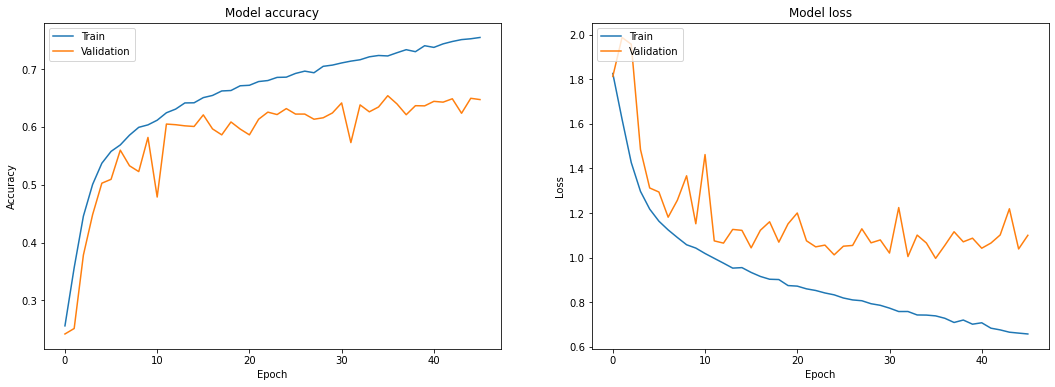

In [101]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluate Test Performance

In [102]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6573



> ### Great! :) 
> ### This is an exciting result because the [model that won the competition had 71.1% accuracy](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/leaderboard?source=post_page), which means this result puts us into 5th place!
        
   ![KaggleRanking](https://i.imgur.com/l8LnPfe.png)

## More Analysis using Confusion Matrix

Confusion Matrix is applied and plotted to find out which emotion usually get confused with each other.

In [103]:
emotion_labels = ['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

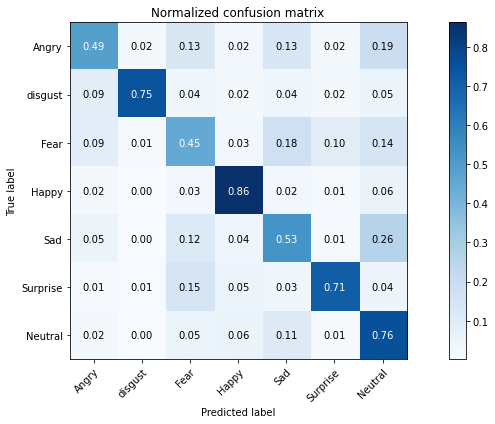

In [104]:
# Plot normalized confusion matrix
plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
['Angry','disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

In [111]:
exp_map = {0 : 'anger', 1:'disgust' , 6 : 'contempt', 2 : 'fear', 3 : 'happy',4 :'sadness',5 :'surprise'}

In [110]:
import math

In [105]:
def anger(p):
    
    t = 0.343* p + 1.003
    return 2.332 * math.log(t)

def fear(p):
    
    t = 1.356* p + 1
    return 1.763 * math.log(t)

def contempt(p):
    t = 0.01229* p + 1.036
    return 5.03 * math.log(t)

def disgust(p):
    t = 0.0123* p + 1.019
    return 7.351 * math.log(t)

def happy(p):
    t = 5.221e-5* p + 0.9997
    return 532.2 * math.log(t)

def sad(p):
    t = 0.1328* p + 1.009
    return 2.851 * math.log(t)

def surprise(p):
    t = 0.2825* p + 1.003
    return 2.478 * math.log(t)

In [137]:
samp = test_X[1236]
samp = np.reshape(samp,(1,48,48,1))
samp.shape

(1, 48, 48, 1)

In [198]:
ex_p = model.predict(samp)
ex_p.shape

(1, 7)

In [193]:
correct = []
correcty = []
res = model.predict(X_test)
for i in range(len(test_Y)):
    if np.argmax(res[i]) == np.argmax(test_Y[i]):
        correct.append(res[i])
        correcty.append(test_Y[i])
correct = np.array(correct)
correcty = np.array(correcty)
correct.shape

(2359, 7)

In [108]:
func = [anger,disgust, fear, happy, sad, surprise,contempt]

In [195]:
exp_stress = {}
for i,face in enumerate(correct):
    f = np.argmax(face)
    x = np.max(face)*100
    
    s = func[f](x)
    sp = s/9*100
    
    if f not in exp_stress.keys():
        exp_stress[f] = []
        exp_stress[f].append([sp, f, face, correcty[i]])
    else:
        exp_stress[f].append([sp, f, face, correcty[i]])
        

In [196]:
for i in range(7):
    for j in range(len(exp_stress)):
        print(exp_stress[i][j])

[69.08256594563444, 0, array([0.39012513, 0.10154953, 0.1554682 , 0.00228104, 0.07986037,
       0.009149  , 0.26156667], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[89.21478875801037, 0, array([8.82830322e-01, 2.83265632e-04, 1.08486935e-01, 3.61796956e-05,
       8.06322135e-03, 1.10489098e-04, 1.89525381e-04], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[80.62347376609765, 0, array([0.6254406 , 0.00397846, 0.03017615, 0.00431542, 0.08544379,
       0.00131099, 0.24933459], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[89.42450781805717, 0, array([8.9024240e-01, 2.2452775e-02, 2.0808045e-02, 2.6065891e-03,
       6.2509269e-02, 5.6670196e-05, 1.3242420e-03], dtype=float32), array([1., 0., 0., 0., 0., 0., 0.], dtype=float32)]
[91.60676023534016, 0, array([9.7103655e-01, 2.1981692e-03, 2.8613207e-03, 4.7765352e-05,
       1.5937068e-02, 5.5792730e-04, 7.3611406e-03], dtype=float32), array([1., 0., 0., 0., 0., 0., 0

-------------------------------------------------------------------

**Future Work:**

    (i) To further fine tuning model using grid_search, specifically:
        a. Different optimizer such as Adam, RMSprop, Adagrad.
        b. experimenting dropout with batch-normalization.
        c. experimenting different dropout rates. 

    (ii) To collect more data and train the model with balance dataset.



---------------------------------------------------------------------------------------------------
### Extra:

### Batch Normalization

#### (i) Apply Batch-Normalization before or after activation function?
*Regarding this issue, it is still occasionally a topic of debate. However, in this project, we applied BN before ReLu as we are trying to follow the original BatchNorm paper. The following is the exact text from the paper...*
    
> We add the BN transform immediately before the nonlinearity, by normalizing x = Wu+ b. 
We could have also normalized the layer inputs u, but since u is likely the output of another nonlinearity, 
the shape of its distribution is likely to change during training, and constraining its first and second 
moments would not eliminate the covariate shift. In contrast, Wu + b is more likely to have a symmetric, 
non-sparse distribution, that is “more Gaussian” (Hyv¨arinen & Oja, 2000); normalizing it is likely to 
produce activations with a stable distribution.


#### (ii) Is it better to use DropOut together with Batch-Normalization?
*Again, it is another common debate topic in DL community. In this project, we totally eliminate the use of dropout and focusing batch-normalization technique only. This is because, Batch normalization already offers some regularization effect, reducing generalization error, perhaps no longer requiring the use of dropout for regularization.* 

> Batch Normalization allows us to use much higher learning rates and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need for Dropout

More details -> [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167).




---------------------------------------------------------------------------------------------------


*It was a fun project, Happy Kaggling :) *
-----------------------------------